# Proyecto Sprint 15

## Introducción
### Objetivo del proyecto

Construir varios modelos de regresión para predecir la cantidad de pedidos de taxis para la próxima hora, con el fin de atraer a más conductores durante las horas pico. - La métrica RECM en el conjunto de prueba no debe ser superior a 48.


### Contexto del negocio (Sweet Lift Taxi) - Instrucciones

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.


Instrucciones del proyecto.

Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
Analiza los datos.
Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos
### Estructura del dataset

In [1]:
# Carga de librerias
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<div style="color: black ; background-color: LightSeaGreen">
Se cargan los datos y se hace un analisis exploratorio, vemos las primeras filas para familiarizarnos con las columnas disponibles asi como el tipo de datos que se manejan.
    
Estructura de los datasets:
26,496 filas, no hay valores nulos, pero si hay 2 columnas

Tipos de datos:
int y object
    
En este punto pasare a forma de indice la columna 'datetime' para poder remuestrear y completar el analisis de proyecto

## Preparación de los datos
### Convertir a tipo de datos correcto.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)
print(data.index.is_monotonic_increasing)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [6]:
data= data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='datetime'>

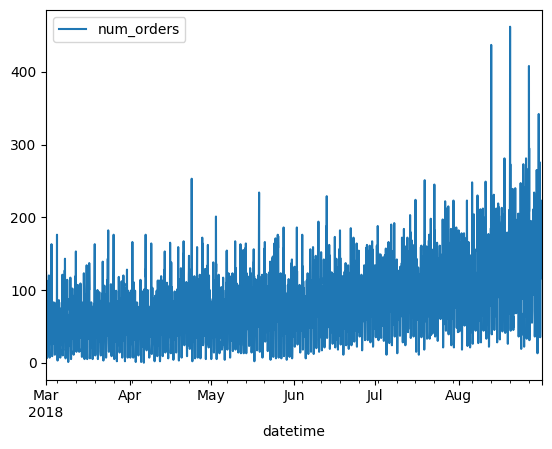

In [7]:
data.plot()

<div style="color: black ; background-color: LightSeaGreen">
Se hace el remuestreo y ahora ya cada punto de datos de los datos originales caen dentro de intervalos de una hora.


## Análisis de datos


<AxesSubplot:xlabel='datetime'>

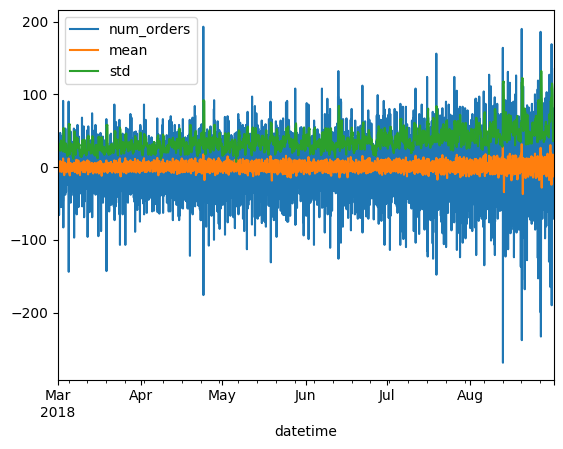

In [8]:
data_hourly = data.copy()
data_hourly -= data_hourly.shift()
data_hourly['mean'] = data_hourly['num_orders'].rolling(10).mean()
data_hourly['std'] = data_hourly['num_orders'].rolling(10).std()
data_hourly.plot()

<div style="color: black ; background-color: LightSeaGreen">
Decido hacer una copia de los datos para no afectar el dataframe original que usaré para las predicciones, esta copia la utilizo para crear un gráfico.
    
Se visualiza la serie original de pedidos ('num_orders') junto a su media móvil y desviación estándar móvil.  
- La **media móvil** (línea naranja) revela una tendencia creciente suave a lo largo del tiempo.  
- La **desviación estándar móvil** (línea verde) indica que la variabilidad en los pedidos también ha aumentado ligeramente, especialmente en los últimos meses.

Esto sugiere que el sistema presenta una mayor inestabilidad reciente, lo que podría influir en la capacidad predictiva de los modelos.

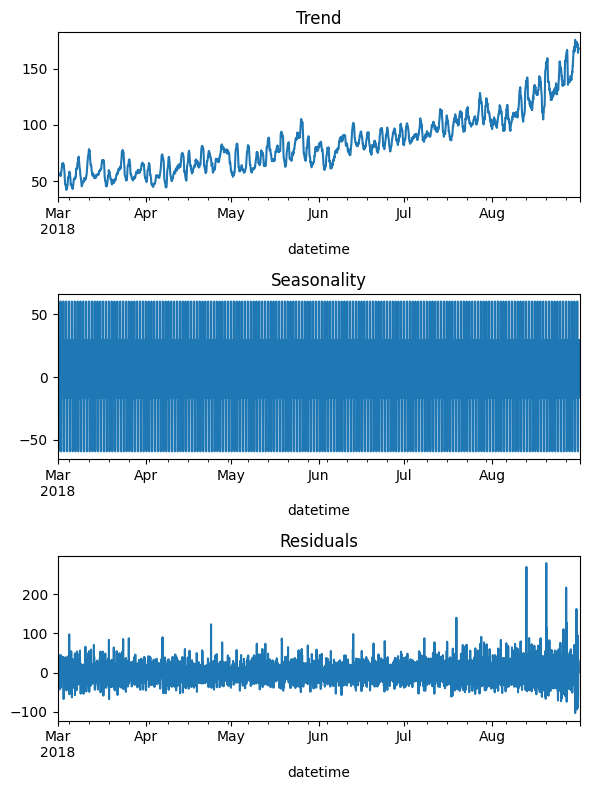

In [9]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="color: black ; background-color: LightSeaGreen">
    
1.- Tendencia (Trend): muestra un crecimiento constante en la cantidad de pedidos de taxis desde marzo hasta agosto, indicando una demanda creciente.

2.- Estacionalidad (Seasonality): evidencia un patrón diario repetitivo, lo cual sugiere que los pedidos fluctúan de manera similar cada 24 horas.

3.- Residuos (Residuals): representan las variaciones no explicadas por la tendencia ni por la estacionalidad. Se observan algunos picos, pero en general se mantiene estable.

In [10]:
# Baseline con datos originales
train_base, test_base = train_test_split(data, shuffle=False, test_size=0.1)

print('Cantidad media de pedidos de taxis:', test_base['num_orders'].median())
pred_median = np.ones(test_base.shape) * train_base['num_orders'].median()
print('RECM:', mean_squared_error(test_base, pred_median, squared=False))

Cantidad media de pedidos de taxis: 135.0
RECM: 87.15277582981295


<div style="color: black ; background-color: LightSeaGreen">

A modo de prueba de cordura o como medida inicial, hago el cálculo de la RECM sin modelos predictivos, unicamnete por medio de la mediana, este valor no representa ni se aprueba como válido, sin embargo puede introducir un poco al analisis, no cumple con el requisito del proyecto.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    
make_features(data, 24, 24)
# max lag = 24 Esto me permite capturar el comportamiento del día anterior completo.
# mean size = 24 Calcula la media del día anterior.

<div style="color: black ; background-color: LightSeaGreen">

Ya que los modelos requieren de caracteristicas y el dataframe unicamente tiene 1 columna, es necesario crear caracteristicas, use la función de arriba para hacer dichas caracteristicas, se agregaron atributos del tiempo (hora, día, día de la semana, etc.), lags (valores anteriores) y promedios móviles (tendencia reciente)

Todo eso le da al modelo contexto del pasado para predecir el futuro.

## Selección y entrenamiento de modelos

### Regresión Lineal

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.shape)
print(test.shape)

(3950, 30)
(442, 30)


<div style="color: black ; background-color: LightSeaGreen">

La muestra de prueba debe ser el 10% del conjunto de datos inicial y elimino los valores NaN que surgen por el paso anterior.

In [14]:
#Separación de los conjuntos
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#Modelo
model_lr = LinearRegression()
model_lr.fit(features_train, target_train) 


# Predicciones
preds_train = model_lr.predict(features_train) 
preds_test = model_lr.predict(features_test) 

# Evaluación
result_train_lr= (mean_squared_error(target_train, preds_train, squared=False))
result_test_lr= (mean_squared_error(target_test, preds_test, squared=False))

print("RECM para el conjunto de entrenamiento:", result_train_lr, "- Regresión lineal")
print("RECM para el conjunto de prueba:", result_test_lr, "- Regresión lineal")

RECM para el conjunto de entrenamiento: 25.83620093576961 - Regresión lineal
RECM para el conjunto de prueba: 45.20703061123371 - Regresión lineal


### Random Forest

In [15]:
RS = 12345
#Modelo
model_rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=RS
)

model_rfr.fit(features_train, target_train)

# Predicciones
preds_train_rfr = model_rfr.predict(features_train)
preds_test_rfr = model_rfr.predict(features_test)

# Evaluación
result_train_rfr = mean_squared_error(target_train, preds_train_rfr, squared=False)
result_test_rfr = mean_squared_error(target_test, preds_test_rfr, squared=False)

print("RECM para el conjunto de entrenamiento:", result_train_rfr, "- Random Forest")
print("RECM para el conjunto de prueba:", result_test_rfr, "- Random Forest")

RECM para el conjunto de entrenamiento: 14.585229819117606 - Random Forest
RECM para el conjunto de prueba: 44.018968110519765 - Random Forest


### Gradient Boosting Regressor

In [16]:
#Modelo
model_gbr = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=RS
)

model_gbr.fit(features_train, target_train)

# Predicciones
preds_train_gbr = model_gbr.predict(features_train)
preds_test_gbr = model_gbr.predict(features_test)

# Evaluación
result_train_gbr = mean_squared_error(target_train, preds_train_gbr, squared=False)
result_test_gbr = mean_squared_error(target_test, preds_test_gbr, squared=False)

print("RECM para el conjunto de entrenamiento:", result_train_gbr, "- Gradient Boosting Regressor")
print("RECM para el conjunto de prueba:", result_test_gbr, "- Gradient Boosting Regressor")

RECM para el conjunto de entrenamiento: 14.758059316011487 - Gradient Boosting Regressor
RECM para el conjunto de prueba: 44.401909242391525 - Gradient Boosting Regressor


### Gráfico valores reales vs predicciones (Mejor modelo)

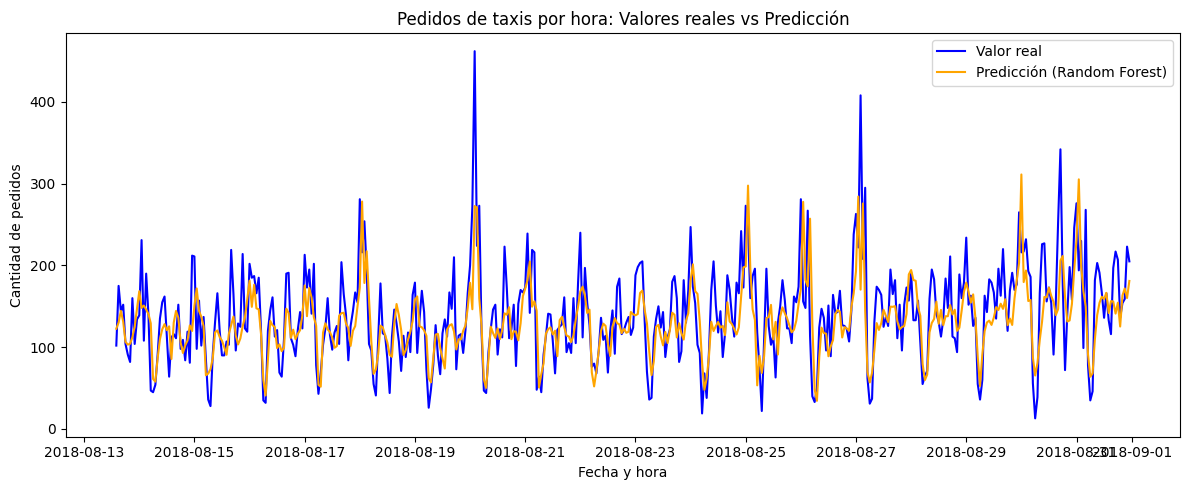

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(test.index, target_test, label='Valor real', color='blue')
plt.plot(test.index, preds_test_rfr, label='Predicción (Random Forest)', color='orange')

plt.title('Pedidos de taxis por hora: Valores reales vs Predicción')
plt.xlabel('Fecha y hora')
plt.ylabel('Cantidad de pedidos')
plt.legend()
plt.tight_layout()
plt.show()

## Análisis de resultados

| Modelo                    | RECM - Conjunto de **prueba** |-| 
|---------------------------|--------------------------|-| 
| Mediana                   | 87.16            | -| 
| Regresión lineal          |45.21                | - |
| Bosque aleatorio          |44.02                 | -> **Más preciso** |
| Gradient Boosting Regressor                   |44.41|- |


**Exploración inicial:**
- Se detectó una **tendencia creciente** en la demanda de taxis a lo largo de los meses.
- Se observó una **estacionalidad diaria clara**, con patrones repetitivos cada 24 horas.
- También se identificó un **ligero aumento en la variabilidad** (desviación estándar) en los últimos meses.

**Creación de características:**
- Se crearon variables basadas en el calendario (`hora`, `día`, `mes`, `día de la semana`), retrasos temporales (`lags`) y promedios móviles (`rolling mean`).
- Esto transformó la serie temporal en un problema supervisado adecuado para modelos de regresión.

### Gráfico valores reales vs predicciones (Mejor modelo)

<div style="color: black ; background-color: LightSeaGreen">
En esa gráfica se comparan los valores reales de pedidos por hora con las predicciones del modelo Random Forest.

- Se observa que el modelo logra seguir correctamente la forma general de la serie temporal.
- Capta tanto la tendencia como las variaciones horarias (estacionalidad diaria).
- Aunque no siempre alcanza los valores máximos exactos, predice con muy buena aproximación la mayoría de los picos y caídas.

Esto refuerza la validez del modelo como herramienta confiable para la predicción horaria de la demanda de taxis.

## Conclusiones

Todos los modelos cumplieron con el criterio del proyecto:  
> **RECM ≤ 48 en el conjunto de prueba**

- Los modelos de ensamble (Random Forest y Gradient Boosting) mostraron el mejor desempeño.
- Se logró una predicción precisa y generalizable, sin signos evidentes de sobreajuste.
- **El proyecto cumple con todos los requisitos técnicos y métricos definidos.**



# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48